# Introduction

This notebook takes results from running Integration_Time_full_spec.py for individual stars (see run_Int_Time_all.py for a loop over all stars. It takes a couple of hours to run the full set. A set has been included in this distribution. The parameters assumed in the set provided are 120 mas slit for spectroscopy and an end-to-end efficiency of 3.5%.



In [1]:
%matplotlib inline
from pylab import *
rcParams['font.size']=14

import os
import pandas
exocat = pandas.read_excel('./ExoCat1.xls', header=0)

from Star import Star
from Completeness import Completeness_MC_Calculator

CMC_calc = Completeness_MC_Calculator(LUT_path = './')

def load_tables(fnm):
    f = np.load(fnm)  
    #print('List of keys in file', fnm)
    #for key in f.keys(): print('\t',key,)
    #print('')
    e2e_IFS_throughput_array   = f['e2e_IFS_throughput_array']
    e2e_IMG_throughput_array   = f['e2e_IMG_throughput_array']
    contrast_array             = f['contrast_array']
    
    psf_mas_array          = f['psf_mas_array']
    spc_R_array            = f['spc_R_array']
    diameter_array         = f['diameter_array']
    
    IWA_array              = f['IWA_array']
    nzodi_array            = f['nzodi_array']
    planet_radius_array    = f['planet_radius_array'] 
    img_SNR_cuts           = f['img_SNR_cuts'] 
    spc_SNR_cuts           = f['spc_SNR_cuts'] 
    T_int_array            = f['T_int_array']
    Completeness_matrix    = f['Completeness_matrix'] 
    solar_glint_level      = f['solar_glint_level']
    return diameter_array, psf_mas_array, spc_R_array,  e2e_IFS_throughput_array, e2e_IMG_throughput_array, contrast_array, IWA_array, nzodi_array, planet_radius_array, img_SNR_cuts, spc_SNR_cuts, solar_glint_level, T_int_array, Completeness_matrix

data_dir = './HZ_Completeness_Runs/'



In [2]:
'''
This list assumes the star has been run through Integration_Time_full_spec.py
Additional targets, including onces removed from the list due to other reasons, are included in commented text.
'''

star_HID_list = [
        #16537, #epsilon Eridani, dropped due to high zodi
        8102,   #tau Ceti
        37279,  #Procyon A
        108870, #epsilon Indi A
        32349,  #Sirius A
        19849,  #omicron 2 Eridani
        97649,  #Altair
        99240,  #delta Pavonis
        15510,  #82 Eridani
        96100,  #sigma Draconis
        2021,   #beta Hyi
        61317,  #beta CVn
        22449,  #1 Ori
        #91262, #Vega, dropped due to high zodi
        #86974, #Mu Herculis, dropped to binary companion contamination
        113368, #Fomalhaut
        17378,  #Delta Eridani
        27072,  #Gamma Leporis
        1599,   #Zeta Tucanae
        ]
        #
        #64394,  #Beta Comae Berenices
        #105858, #Gamma Pavonis
        #14632,  #24 Capricorni
        #67927,  #Eta Bootis            
        #57757,  #Beta Virginis
        #78072,  #Gamma Serpentis
        #37826,  #Pollux
        # Even more extended list
'''
        64924, # 61 Virginis 
        57632, # Denebola 
        77952, # Beta Trianguli Australis, companion 155 as 
        102422, # Eta Cephei
        7981, # 107 Piscium
        114622, # HR 8832, companion at 106.6 as
        15457, # Kappa1 Ceti, candidate binary star but unconfirmed
        77257, # Lambda Serpentis
        105090, # AX Microscopii
        70497, # Theta Bootis
        105199, # Alpha Cephei
        29271, # Alpha Mensae
        28103, # Eta Leporis
        116771, # Iota Piscium
        23693, # Zeta Doradus
        49908, # Groombridge 1618
        16852, # 10 Tauri
        59199, # Alpha Corvi
        71908, # Alpha Circini
        3765, # HD 4628
        56997, # 61 Ursae Majoris
        84478, # 36 Ophiuchi C
        50954, # HR 4102
        102485, # Psi Capricorni
        89962, # Eta Serpentis
        24813, # Lambda Aurigae
        114046, # Lacaille 9352
        68933, # Theta Centauri
        54035, # Lalande 21185
        32362, # Xi Geminorum
        39757, # Rho Puppis
        54872, # Delta Leonis
        112447, # Xi Pegasi
        ] 
'''


'\n        64924, # 61 Virginis \n        57632, # Denebola \n        77952, # Beta Trianguli Australis, companion 155 as \n        102422, # Eta Cephei\n        7981, # 107 Piscium\n        114622, # HR 8832, companion at 106.6 as\n        15457, # Kappa1 Ceti, candidate binary star but unconfirmed\n        77257, # Lambda Serpentis\n        105090, # AX Microscopii\n        70497, # Theta Bootis\n        105199, # Alpha Cephei\n        29271, # Alpha Mensae\n        28103, # Eta Leporis\n        116771, # Iota Piscium\n        23693, # Zeta Doradus\n        49908, # Groombridge 1618\n        16852, # 10 Tauri\n        59199, # Alpha Corvi\n        71908, # Alpha Circini\n        3765, # HD 4628\n        56997, # 61 Ursae Majoris\n        84478, # 36 Ophiuchi C\n        50954, # HR 4102\n        102485, # Psi Capricorni\n        89962, # Eta Serpentis\n        24813, # Lambda Aurigae\n        114046, # Lacaille 9352\n        68933, # Theta Centauri\n        54035, # Lalande 21185\n   

In [3]:
'''
Parse the star list above into file names.
You will have to check the format of your output filenames to make sure they match what the output of your runs.
'''
fnm_list = []
for hip in star_HID_list:
    fnm = 'star_%d_imgspc.npz'%hip
    fnm_list.append(fnm)



In [36]:
'''
Loop over the list of files to extract completeness values. 
'''

eta_Earth_val  = 0.24
eta_Earth = eta_Earth_val*np.ones(len(fnm_list))

Completeness_target = 0.5

HIP_list       = -1*np.ones(len(fnm_list))
orb_T_int_list = -1*np.ones(len(fnm_list))
svs_C_list     = -1*np.ones(len(fnm_list))
orb_C_list     = -1*np.ones(len(fnm_list))
spc_C_list     = -1*np.ones(len(fnm_list))
bth_C_list     = -1*np.ones(len(fnm_list))
exozod_vals = []

P_4 = []
P_6 = []
P_8 = []
P_10 = []
P_12 = []
P_max = []

E_4 = []
E_6 = []
E_8 = []
E_10 = []
E_12 = []
E_max = []

count = 0
for fnm in fnm_list:
    diameter_array, psf_mas_array, spc_R_array, e2e_IFS_throughput_array, e2e_IMG_throughput_array, contrast_array, IWA_array, nzodi_array, planet_radius_array, img_SNR_cuts, spc_SNR_cuts, solar_glint_level, T_int_array, Completeness_matrix = load_tables('%s%s'%(data_dir,fnm))
    if(count==0):
        print('Parameters Simulated')
        print('\tdiameter\t',*diameter_array)
        print('\tpsf_mas\t\t',*psf_mas_array)
        print('\tspc_R\t\t',*spc_R_array)
        print('\tifs throughput\t',*e2e_IFS_throughput_array)
        print('\timg throughput\t',*e2e_IMG_throughput_array)
        print('\tContrast\t',*contrast_array)
        print('\tIWA\t\t',*IWA_array)
        print('\tzodi\t\t',*nzodi_array)      
        print('\tpl radius\t',*planet_radius_array)   
        print('\timg_snr_cut\t',*img_SNR_cuts)
        print('\tspc_snr_cut\t',*spc_SNR_cuts)  
        print('\tsolar_glint_lev\t',solar_glint_level)  
        print('\tint Time (days)\t',*np.around((T_int_array/(60.**2*24.)),3)) 
    #print('Completeness_matrix.shape', Completeness_matrix.shape)
    hip = int(fnm.split('_')[1])
    #if hip == 16537: continue
    HIP_list[count] = hip
    #C_array_1.append(Completeness_matrix[i_thr, i_con, i_iwa, i_exz, i_rpl, i_snr, 9, i_comp]) # 4.5 % throughput, 1 day integration time
    #C_array_2.append(Completeness_matrix[4, i_con, i_iwa, i_exz, i_rpl, i_snr, 9, i_comp])     # 15% throughput, 1 day integration time
    # loop through parameters and see , which combinations pass. 
    i_entry = np.where(exocat['HIP'] == hip)[0][0]
    exocat_star =  exocat.iloc[i_entry]
    star_model = Star(L_bol = exocat_star['Lbol'], d_pc = exocat_star['d(pc)'], Temperature=exocat_star['Teff'], Mass = exocat_star['M*(Msun)'], MV = exocat_star['Mv'])

    # get HZ period for eta_Erth SAG-13
    #Period_min_yr = CMC_calc.get_orbital_period(0.7 * np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    #Period_max_yr = CMC_calc.get_orbital_period(1.77* np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    #print Period_min_yr, Period_max_yr
    #eta_Earth_old[count] = Gamma/alpha/beta * (1.4**alpha - 0.7**alpha) * (Period_max_yr**beta - Period_min_yr**beta)

    '''
    # check you get 2.4 for solar system parameters
    star_model.Mass = 1.
    exocat_star['Lbol'] = 1.
    '''

    # get HZ period for eta_Erth a la HabEx
    Period_min_yr = CMC_calc.get_orbital_period(0.95 * np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    Period_max_yr = CMC_calc.get_orbital_period(1.67* np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    #print Period_min_yr, Period_max_yr
    scale_val = (0.95 * np.sqrt(exocat_star['Lbol']))**0.5/(Period_min_yr)**(1./3.)
    #print 'uxuxu', scale_val
    GM_sun_AU3_yr2 = 39.4876393
    GM_star = GM_sun_AU3_yr2*star_model.Mass
    scale_val = (GM_star/(2.*pi)**2)**(1./6.)
    #print star_model.Mass
    #print 'GM_star', GM_star
    #print GM_star/(2.*pi)**2, (GM_star/(2.*pi)**2)**(1./6.)
    scale_val  = (GM_star/(2.*pi)**2)**(1./6.)
    #eta_Earth[count]  = 1.4**alpha * (Period_max_yr**beta - Period_min_yr**beta) / beta
    #eta_Earth[count] -= ((exocat_star['Lbol'])**0.25*0.8/scale_val)**alpha * (Period_max_yr**(beta-alpha/3.) - Period_min_yr**(beta-alpha/3.)) / (beta-alpha/3.)
    #eta_Earth[count] *= Gamma/alpha



    #print 'exocat_star[\'COMMON\']: ', exocat_star['COMMON']

    print('=============================')
    print(hip, exocat_star['COMMON'])
    #thr_val, con_val = 0, 0 #Required
    thr_val, con_val = 1, 1 #CBE
    for i_thr in [thr_val]: # 2 is 4.5% in spec
        for i_con in [con_val]: # 2 is 1.e-10
            for i_iwa in [0]: # 3 is 100 mas
                # this line is modified to sample zodi brightnesses
                medians = [13., 26., 5., 20.]
                sigmas  = [1.5, 1.2, 2.5, 1.6]
                median = medians[2]
                sigma = sigmas[2]
                exozod = np.random.lognormal(np.log(median),sigma)
                exozod = 4.5
                #print('exozod', exozod, round(exozod * 2) / 2, nzodi_array[np.min([int(round(exozod * 2)),20])])
                i_exozod = int(round(exozod * 2))
                exozod_vals.append(exozod)
                #i_exozod = 6
                #for i_exz in [6]: # 6 is 3 zodi
                for i_exz in [np.min([i_exozod,20])]: # 6 is 3 zodi
                    for i_rpl in [0]: # 1 is 6371.
                        for i_snr in [0]: # 0 is snr 5 and 1 is snr 7 for imaging, it is 20 for spectral with R=50 in both cases
                            print('=============================')
                            print('\tdiameter [m]\t%1.2f'%(diameter_array[0]))
                            print('\tpsf [mas]\t%1.2f'%(psf_mas_array[0]))
                            print('\tspc_R\t\t%1.2f'%(spc_R_array[0]))
                            print('\tthroughput\t%1.2e %1.2e'%(e2e_IFS_throughput_array[i_thr], e2e_IMG_throughput_array[i_thr]))
                            print('\tContrast\t%1.2e'%contrast_array[i_con])
                            print('\tIWA [mas]\t%1.0f'%IWA_array[i_iwa])
                            print('\tzodi\t\t%1.1f'%nzodi_array[i_exz])      
                            #print('\tpl radius\t%1.0f'%planet_radius_array[i_rpl])   
                            print('\timg_snr_cut\t%1.0f'%img_SNR_cuts[i_snr])
                            print('\tspc_snr_cut\t%1.0f'%spc_SNR_cuts[i_snr])
                            print('\tsolar_glint_lev\t%1.1f'%solar_glint_level)
                            print('\tPeriod (yr): \t%1.1f - %1.1f'%(Period_min_yr, Period_max_yr))
                            print('=============================')
                            #print 'int Time\t%1.1e'%(T_int_array[i_tint]/(60.**2*24.))  
                            for i_tint in range(0, len(T_int_array)): # 9 is 1 day integration time
                                #print Completeness_matrix
                                # i_comp: 
                                # 0 is single visit obs completelenss, (SNR>5)
                                # 1-4 are at least n of 4 obs for n in 1-4 (SNR>5)
                                # 5 is at least 1 of 4 spectral measurements with SNR>20
                                # 6 is at least 3 of 4 obs with SNR>5 and 1 of 4 spec with SNR>20
                                #i_comp  = 3 # 3 of 4 detections with SNR > 5
                                i_comp_svs  = 0
                                i_comp_orb  = 3
                                i_comp_spc  = 5
                                i_comp_bth  = 6
                                #print 'spc_SNR_cuts', img_SNR_cuts
                                #if Completeness_matrix[i_thr, i_con, i_iwa, i_exz, i_rpl, i_snr, i_tint, i_comp_orb]>Completeness_target:
                                #print('Int Time (days), Single Visit Completeness')
                                if Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]>Completeness_target and T_int_array[i_tint]/(60.**2 * 24.)<30. and i_tint>=2 and i_tint<=9:
                                    #print('--', '%1.1f'%(T_int_array[i_tint]/(60.**2 * 24.)),'%1.2f'%(Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]))
                                    if(orb_T_int_list[count]==-1):
                                       orb_T_int_list[count] = T_int_array[i_tint]/(60.**2 * 24.)
                                       svs_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_svs]
                                       orb_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]
                                       spc_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_spc]
                                       bth_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_bth]

                                if i_tint>6 and orb_T_int_list[count]==-1:
                                       print('++',i_tint, '%1.1f'%(T_int_array[6]/(60.**2 * 24.)),Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb])
                                       orb_T_int_list[count] = T_int_array[6]/(60.**2 * 24.)
                                       # orb_C_list[count]     =  Completeness_matrix[i_thr, i_con, i_iwa, i_exz, i_rpl, i_snr, 13, i_comp]
                                       svs_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_svs]
                                       orb_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_orb]
                                       spc_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_spc]
                                       bth_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_bth]

                                if i_exozod > 20:
                                       svs_C_list[count]     =  0.
                                       orb_C_list[count]     =  0.
                                       spc_C_list[count]     =  0.
                                       bth_C_list[count]     =  0.

    count+=1
    #print 'count', count, 'len(spc_C_list_cut)', len(spc_C_list_cut)
print('i, T_int_array[i]/(60.**2 * 24.)')
for i in range(0,len(T_int_array)):
    print(i, T_int_array[i]/(60.**2 * 24.))
    #i_tint = 16 # 25 day integration time
    #i_comp=1 # 0 is single visit, 1 is at least 1 of 4, 2 is at least 2 of 4, etc.
#C_array_1 = np.array(C_array_1)
#C_array_2 = np.array(C_array_2)
cut = np.logical_and(orb_T_int_list>0., orb_T_int_list<30.)
print('orb_T_int_list', orb_T_int_list)
HIP_list_cut       = HIP_list[cut]
orb_T_int_list_cut = orb_T_int_list[cut]
svs_C_list_cut     = svs_C_list[cut]
orb_C_list_cut     = orb_C_list[cut]
spc_C_list_cut     = spc_C_list[cut]
bth_C_list_cut     = bth_C_list[cut]

#idx = argsort(orb_T_int_list_cut)
#idx = argsort(orb_C_list_cut)[::-1]
#idx = argsort(spc_C_list_cut)[::-1]
#idx  = argsort(bth_C_list_cut)[::-1]
idx = range(len(bth_C_list_cut))
print(idx)
#idx = [ 2,  5, 14,  9,  7, 15,  6,  1, 11, 12,  8, 13, 10,  4,  3,  0]
#idx = [ 2,  5,  9, 14,  7, 15, 13, 12, 11, 10,  8,  6,  4,  3,  1,  0]
print('len(spc_C_list_cut), len(eta_Earth)', len(spc_C_list_cut), len(eta_Earth))
idx2 = argsort(spc_C_list_cut*eta_Earth)[::-1]
#idx = idx2.copy()
idx_o  = argsort(orb_C_list_cut)[::-1]
idx_s  = argsort(spc_C_list_cut)[::-1]
idx_b  = argsort(bth_C_list_cut)[::-1]

name_array = []
count=1
for i in idx:
    i_entry = np.where(exocat['HIP'] == HIP_list_cut[i])[0][0]
    exocat_star =  exocat.iloc[i_entry]
    #print 'exocat_star[\'COMMON\']: ', exocat_star['COMMON']
    name_array.append(exocat_star['COMMON']+' (%d)'%count)
    #print 'count', count
    count+=1

name_array2 = []
count=1
for i in idx2:
    i_entry = np.where(exocat['HIP'] == HIP_list_cut[i])[0][0]
    exocat_star =  exocat.iloc[i_entry]
    #print 'exocat_star[\'COMMON\']: ', exocat_star['COMMON']
    name_array2.append(exocat_star['COMMON']+' (%d)'%count)
    #print 'count', count
    count+=1

E_4.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[3])
E_6.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[5])
E_8.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[7])
E_10.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[9])
E_12.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[11])
E_max.append(cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])[len(idx2)-1])

P_4.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[3])
P_6.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[5])
P_8.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[7])
P_10.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[9])
P_12.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[11])
P_max.append((1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[len(idx2)-1])
print('P_4   %1.2f'%P_4[0])
print('P_6   %1.2f'%P_6[0])
print('P_8   %1.2f'%P_8[0])
print('P_10  %1.2f'%P_10[0])
print('P_12  %1.2f'%P_12[0])
print('P_max %1.2f'%P_max[0])
E_vals = cumsum(bth_C_list_cut[idx2]*eta_Earth[idx2])
P_vals = (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))
for k in range(0, len(P_vals)):
    print('\t%d\t%1.2f\t%1.2f'%(k+1, P_vals[k], E_vals[k]))
#print (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[5]
#print (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[7]
#print (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[9]
#print (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[11]
#print (1.-10**cumsum(np.log10(1-bth_C_list_cut[idx2]*eta_Earth[idx2])))[len(idx2)-1]
print('\tthroughput\t%1.2e %1.2e'%(e2e_IFS_throughput_array[i_thr], e2e_IMG_throughput_array[i_thr]))
print('\teta_Earth_val\t%1.2e'%(eta_Earth_val))
sorted_exozod_vals = np.array(sorted(exozod_vals))
sorted_exozod_vals = sorted_exozod_vals[sorted_exozod_vals<=10.]
print('\texozod_vals %1.2f, '%(sorted_exozod_vals[0]),)
for sz in range(1,len(sorted_exozod_vals)-1): print('%1.2f, '%(sorted_exozod_vals[sz]),)
print('%1.2f'%(sorted_exozod_vals[-1]))

Parameters Simulated
	diameter	 2.37
	psf_mas		 65.0
	spc_R		 50.0 50.0
	ifs throughput	 0.02328 0.03395
	img throughput	 0.024 0.035
	Contrast	 1e-10 4e-11
	IWA		 103.0
	zodi		 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0
	pl radius	 6371.0
	img_snr_cut	 5.0 7.0
	spc_snr_cut	 20.0 20.0
	solar_glint_lev	 0.0
	int Time (days)	 0.398 0.631 1.0 1.585 2.512 3.981 6.31 10.0 15.849 25.119 39.811 63.096 100.0
8102 tau Ceti
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11
	IWA [mas]	103
	zodi		4.5
	img_snr_cut	5
	spc_snr_cut	20
	solar_glint_lev	0.0
	Period (yr): 	0.6 - 1.5
37279 Procyon A
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11
	IWA [mas]	103
	zodi		4.5
	img_snr_cut	5
	spc_snr_cut	20
	solar_glint_lev	0.0
	Period (yr): 	3.3 - 7.7
108870 epsilon Indi A
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11

star_8102_imgspc.npz 0.72438 tau Ceti (1)
star_37279_imgspc.npz 0.72285 Procyon A (2)
star_108870_imgspc.npz 0.68672 epsilon Indi A (3)
star_32349_imgspc.npz 0.66143 Sirius A (4)
star_19849_imgspc.npz 0.66782 omicron 2 Eridani (5)
star_97649_imgspc.npz 0.60342 Altair (6)
star_99240_imgspc.npz 0.66444 delta Pavonis (7)
star_15510_imgspc.npz 0.69223 82 Eridani (8)
star_96100_imgspc.npz 0.59421 sigma Draconis (9)
star_2021_imgspc.npz 0.60309 beta Hyi (10)
star_61317_imgspc.npz 0.52562 beta CVn (11)
star_22449_imgspc.npz 0.64574 1 Ori (12)
star_113368_imgspc.npz 0.56831 Fomalhaut (13)
star_17378_imgspc.npz 0.55696 Delta Eridani (14)
star_27072_imgspc.npz 0.54158 Gamma Leporis (15)
star_1599_imgspc.npz 0.51325 Zeta Tucanae (16)
<a list of 11 Text xticklabel objects>


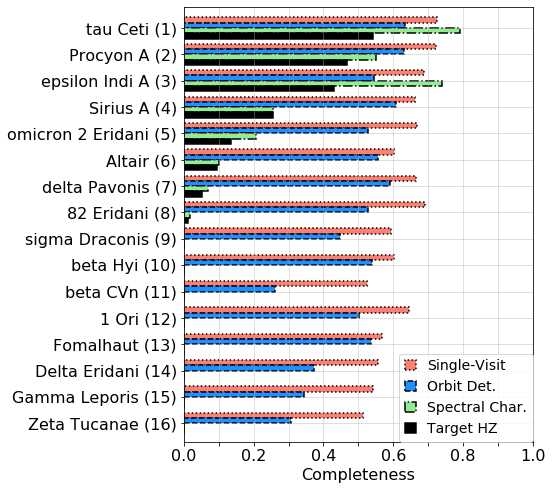

In [34]:
# create plot
rcParams['font.size']=16
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

n_groups = len(svs_C_list_cut[idx])


figure(figsize=(8.5,8))
ax = subplot(111)
index = np.arange(n_groups)[::-1]
bar_width = 0.2
opacity = 0.8

cc=-1
for ii in idx:
    cc+=1
    print(fnm_list[ii], svs_C_list_cut[ii], name_array[cc])
rects1 = plt.barh(index + 2.5*bar_width, svs_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 ls =':',
                 color='salmon',
                 edgecolor='k',
                 lw=1.5,
                 label='Single-Visit')

rects2 = plt.barh(index + 1.5*bar_width, orb_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 lw=1.5,
                 ls = '--',
                 edgecolor='k',
                 color='dodgerblue',
                 #hatch = '///', 
                 label='Orbit Det.',)

rects3 = plt.barh(index + 0.5*bar_width, spc_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 lw=1.5,
                 ls = '-.',
                 edgecolor='k',
                 color='lightgreen',
                 #hatch = '\\', 
                 label='Spectral Char.')

rects4 = plt.barh(index - 0.5*bar_width, bth_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 color='k',
                 edgecolor='k',
                 lw=1.5,
                 label='Target HZ')

yticks(index+bar_width, name_array, rotation=0)
xlabel('Completeness')
#title('Completeness')
ylim(-0.5, 16.)
xticks(np.arange(0.,1.05, 0.1))
plt.legend(loc=4, fontsize=14, borderaxespad=0.0, handlelength=0.8)
grid(True, which='both', alpha=0.5)

print(ax.get_xticklabels())
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)

xlim(0., 1.)
subplots_adjust(left=0.33)
savefig('Completeness_by_target.pdf')